In [ ]:
import warnings, requests, zipfile, io
warnings.simplefilter('ignore')
import pandas as pd
from scipy.io import arff

In [ ]:
f_zip = 'https://ananyakeybucket.s3.amazonaws.com/vertebral_column_data.zip'
r = requests.get(f_zip, stream=True)
Vertebral_zip = zipfile.ZipFile(io.BytesIO(r.content))
Vertebral_zip.extractall()

In [ ]:
data = arff.loadarff('column_2C_weka.arff')
df = pd.DataFrame(data[0])


In [ ]:
class_mapper = {b'Abnormal':1,b'Normal':0}
df['class']=df['class'].replace(class_mapper)

In [ ]:
df.shape

(310, 7)

In [ ]:
df['pelvic_incidence'].describe()

count    310.000000
mean      60.496653
std       17.236520
min       26.147921
25%       46.430294
50%       58.691038
75%       72.877696
max      129.834041
Name: pelvic_incidence, dtype: float64

In [ ]:
df.describe()

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,class
count,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000
mean,60.496653,17.542822,51.930930,42.953831,117.920655,26.296694,0.677419
std,17.236520,10.008330,18.554064,13.423102,13.317377,37.559027,0.468220
min,26.147921,-6.554948,14.000000,13.366931,70.082575,-11.058179,0.000000
25%,46.430294,10.667069,37.000000,33.347122,110.709196,1.603727,0.000000
50%,58.691038,16.357689,49.562398,42.404912,118.268178,11.767934,1.000000
75%,72.877696,22.120395,63.000000,52.695888,125.467674,41.287352,1.000000
max,129.834041,49.431864,125.742385,121.429566,163.071041,418.543082,1.000000


<Axes: >

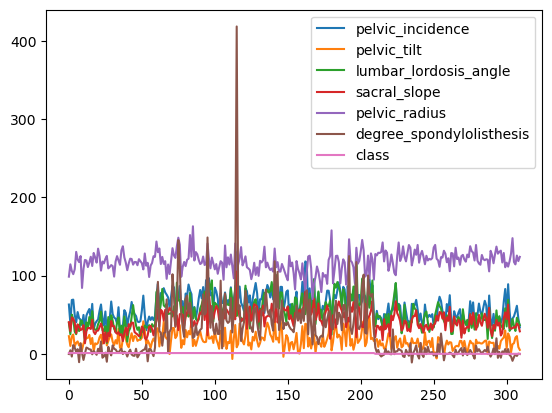

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
df.plot()

<Axes: ylabel='Density'>

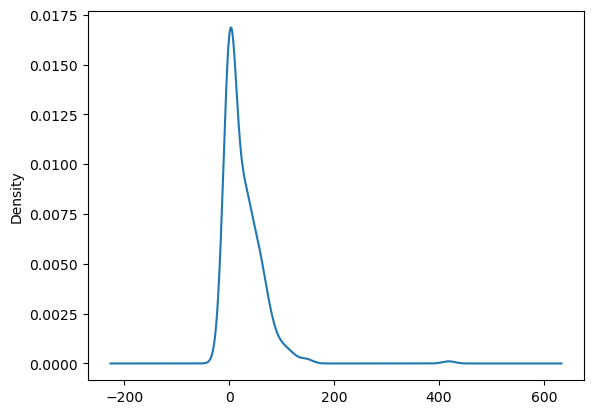

In [ ]:
df['degree_spondylolisthesis'].plot.density()

In [ ]:
df['class'].value_counts()

class
1    210
0    100
Name: count, dtype: int64

In [ ]:
class_mapper = {b'Abnormal':1,b'Normal':0}
df['class']=df['class'].replace(class_mapper)

In [ ]:
corr_matrix = df.corr()
corr_matrix["class"].sort_values(ascending=False)

class                       1.000000
degree_spondylolisthesis    0.443687
pelvic_incidence            0.353336
pelvic_tilt                 0.326063
lumbar_lordosis_angle       0.312484
sacral_slope                0.210602
pelvic_radius              -0.309857
Name: class, dtype: float64

By using seaborn, you can visualize the correlation as a heatmap.

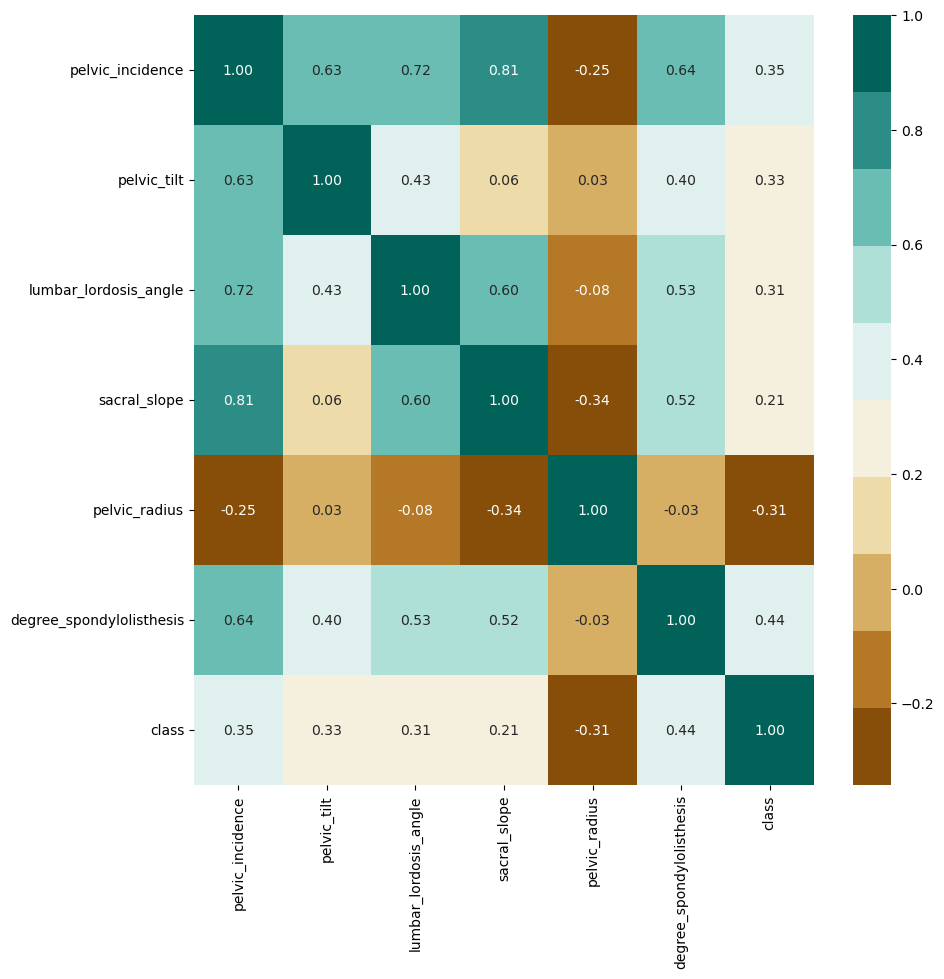

In [ ]:
import seaborn as sns
# Plot figsize
fig, ax = plt.subplots(figsize=(10, 10))
# Generate Color Map
# colormap = sns.diverging_palette(220, 10, as_cmap=True)
colormap = sns.color_palette("BrBG", 10)
# Generate Heat Map, allow annotations and place floats in map
sns.heatmap(corr_matrix, cmap=colormap, annot=True, fmt=".2f")
#ax.set_yticklabels(column_names);
plt.show()

Step 2: Preparing the data
For this lab, you must split the data into three datasets.

An internet search will show many different ways to split datasets. Many code samples that you might find will split the dataset into the target and the features. Then, they will split each of those two datasets into three subsets, which results in a total of six datasets to track.

Moving the target column position
XGBoost requires the training data to be in a single file. The file must have the target value be the first column.

Get the target column and move it to the first position.

In [ ]:
import warnings, requests, zipfile, io
warnings.simplefilter('ignore')
import pandas as pd
from scipy.io import arff
import boto3

In [ ]:
cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]
df = df[cols]

Splitting the data:


You will start by splitting the dataset into two datasets. You will use one dataset for training, and you will split the other dataset again for use with validation and testing.

You will use the train_test_split function from the scikit-learn library, which is a free machine learning library for Python. It has many algorithms and useful functions, such as the one you will use.

For more information about the function, see the Train_test_split documentation.
For more information about scikit-learn, see the scikit-learn guide
Because you don't have a lot of data, you want to make sure that the split datasets contain a representative amount of each class. Thus, you will use the stratify switch. Finally, you will use a random number so that you can repeat the splits.

In [ ]:
from sklearn.model_selection import train_test_split
train, test_and_validate = train_test_split(df, test_size=0.2, random_state=42, stratify=df['class'])

In [ ]:
test, validate = train_test_split(test_and_validate, test_size=0.5, random_state=42, stratify=test_and_validate['class'])

In [ ]:
print(train.shape)
print(test.shape)
print(validate.shape)

(248, 7)
(31, 7)
(31, 7)


In [ ]:
print(train['class'].value_counts())
print(test['class'].value_counts())
print(validate['class'].value_counts())

class
1    168
0     80
Name: count, dtype: int64
class
1    21
0    10
Name: count, dtype: int64
class
1    21
0    10
Name: count, dtype: int64


Uploading the data to Amazon S3:


XGboost will load the data for training from Amazon Simple Storage Service (Amazon S3). Thus, you must write the data to a comma-separated values (CSV) file, and then upload the file to Amazon S3.

Start by setting up some variables to the S3 bucket, then create a function to upload the CSV file to Amazon S3. You can reuse this function.

First, explore the function.

Note the following line:

dataframe.to_csv(csv_buffer, header=False, index=False)

This line writes the pandas DataFrame (which was passed into the function) into the IO buffer that's named csv_buffer. You use a buffer because you don't need to write the file locally.

To stop the column headers from being written out, use header=False. To stop the pandas index from being output, use index=False.

To write the csv_buffer to Amazon S3 as an object, use the put operation on the object, which is a property of the bucket.

In [ ]:
bucket='ananyakeybucket'

prefix='vertebral_column_data'

train_file='vertebral_train.csv'
test_file='vertebral_test.csv'
validate_file='vertebral_validate.csv'

import os

s3_resource = boto3.Session().resource('s3')
def upload_s3_csv(filename, folder, dataframe):
    csv_buffer = io.StringIO()
    dataframe.to_csv(csv_buffer, header=False, index=False)
    s3_resource.Bucket(bucket).Object(os.path.join(prefix, folder, filename)).put(Body=csv_buffer.getvalue())

In [ ]:
upload_s3_csv(train_file, 'train', train)
upload_s3_csv(test_file, 'test', test)
upload_s3_csv(validate_file, 'validate', validate)

# Step 3: Training the model

Now that the data in Amazon S3, you can train a model.

The first step is to get the XGBoost container URI.

In [ ]:
import boto3
from sagemaker.image_uris import retrieve
container = retrieve('xgboost',boto3.Session().region_name,'1.0-1')


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [ ]:
hyperparams={"num_round":"42",
             "eval_metric": "auc",
             "objective": "binary:logistic"}

In [ ]:
import sagemaker
s3_output_location="s3://{}/{}/output/".format(bucket,prefix)
xgb_model=sagemaker.estimator.Estimator(container,
                                       sagemaker.get_execution_role(),
                                       instance_count=1,
                                       instance_type='ml.m4.xlarge',
                                       output_path=s3_output_location,
                                        hyperparameters=hyperparams,
                                        sagemaker_session=sagemaker.Session())

In [ ]:
train_channel = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/train/".format(bucket,prefix,train_file),
    content_type='text/csv')

validate_channel = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/validate/".format(bucket,prefix,validate_file),
    content_type='text/csv')

data_channels = {'train': train_channel, 'validation': validate_channel}

In [ ]:
xgb_model.fit(inputs=data_channels, logs=False)

INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2024-05-02-14-57-19-776



2024-05-02 14:57:19 Starting - Starting the training job.........
2024-05-02 14:58:11 Starting - Preparing the instances for training...........
2024-05-02 14:59:14 Downloading - Downloading input data......
2024-05-02 14:59:49 Downloading - Downloading the training image.......
2024-05-02 15:00:30 Training - Training image download completed. Training in progress....
2024-05-02 15:00:50 Uploading - Uploading generated training model.
2024-05-02 15:01:01 Completed - Training job completed


Hosting the Model

In [ ]:
xgb_predictor = xgb_model.deploy(initial_instance_count=1,
                serializer = sagemaker.serializers.CSVSerializer(),
                instance_type='ml.m4.xlarge')

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2024-05-02-15-01-02-149
INFO:sagemaker:Creating endpoint-config with name sagemaker-xgboost-2024-05-02-15-01-02-149
INFO:sagemaker:Creating endpoint with name sagemaker-xgboost-2024-05-02-15-01-02-149


-------!

In [ ]:
row = test.iloc[0:1,1:]
row.head()

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis
136,88.024499,39.844669,81.774473,48.17983,116.601538,56.766083


In [ ]:
batch_X_csv_buffer = io.StringIO()
row.to_csv(batch_X_csv_buffer, header=False, index=False)
test_row = batch_X_csv_buffer.getvalue()
print(test_row)

88.0244989,39.84466878,81.77447308,48.17983012,116.6015376,56.76608323



In [ ]:
xgb_predictor.predict(test_row)

b'0.9966071844100952'

In [ ]:
xgb_predictor.delete_endpoint(delete_endpoint_config=True)

INFO:sagemaker:Deleting endpoint configuration with name: sagemaker-xgboost-2024-05-02-15-01-02-149
INFO:sagemaker:Deleting endpoint with name: sagemaker-xgboost-2024-05-02-15-01-02-149


Spin up an instance with the model:
    
    
Perform a prediction on all the input values
Write those values to Amazon Simple Storage Service (Amazon S3)
Finally, terminate the instance
You will start by turning your data into a CSV file that the transformer object can take as input. This time, you will use iloc to get all the rows, and all columns except the first column.

In [ ]:
batch_X = test.iloc[:,1:];
batch_X.head()

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis
136,88.024499,39.844669,81.774473,48.179830,116.601538,56.766083
230,65.611802,23.137919,62.582179,42.473883,124.128001,-4.083298
134,52.204693,17.212673,78.094969,34.992020,136.972517,54.939134
130,50.066786,9.120340,32.168463,40.946446,99.712453,26.766697
47,41.352504,16.577364,30.706191,24.775141,113.266675,-4.497958


In [ ]:
batch_X_file='batch-in.csv'
upload_s3_csv(batch_X_file, 'batch-in', batch_X)

In [ ]:
batch_output = "s3://{}/{}/batch-out/".format(bucket,prefix)
batch_input = "s3://{}/{}/batch-in/{}".format(bucket,prefix,batch_X_file)

xgb_transformer = xgb_model.transformer(instance_count=1,
                                       instance_type='ml.m4.xlarge',
                                       strategy='MultiRecord',
                                       assemble_with='Line',
                                       output_path=batch_output)

xgb_transformer.transform(data=batch_input,
                         data_type='S3Prefix',
                         content_type='text/csv',
                         split_type='Line')
xgb_transformer.wait()

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2024-05-02-15-05-05-019
INFO:sagemaker:Creating transform job with name: sagemaker-xgboost-2024-05-02-15-05-05-672


.......................................
[2024-05-02:15:11:39:INFO] No GPUs detected (normal if no gpus installed)
[2024-05-02:15:11:39:INFO] No GPUs detected (normal if no gpus installed)
[2024-05-02:15:11:39:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;
  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }
  server {
    listen 8080 deferred;
    client_max_body_size 0;
    keepalive_timeout 3;
    location ~ ^/(ping|invocations|execution-parameters) {
      proxy_set_header X-Forwarded-For $proxy_add_x_forwarded_for;
      proxy_set_header Host $http_host;
      proxy_redirect off;
      proxy_read_timeout 60s;
      proxy_pass http://gunicorn;
    }
    location / {
      return 404 "{}";
    }
  }
}
[2024-05-02 15:11:39 +0000] [19] [INFO] Star

In [ ]:
s3 = boto3.client('s3')
obj = s3.get_object(Bucket=bucket, Key="{}/batch-out/{}".format(prefix,'batch-in.csv.out'))
target_predicted = pd.read_csv(io.BytesIO(obj['Body'].read()),sep=',',names=['class'])
target_predicted.head(5)

,class
0,0.996607
1,0.777283
2,0.994641
3,0.993690
4,0.939139


In [ ]:
def binary_convert(x):
    threshold = 0.65
    if x > threshold:
        return 1
    else:
        return 0

target_predicted['binary'] = target_predicted['class'].apply(binary_convert)

print(target_predicted.head(10))
test.head(10)

      class  binary
0  0.996607       1
1  0.777283       1
2  0.994641       1
3  0.993690       1
4  0.939139       1
5  0.997396       1
6  0.991977       1
7  0.987518       1
8  0.993334       1
9  0.682776       1


,class,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis
136,1,88.024499,39.844669,81.774473,48.179830,116.601538,56.766083
230,0,65.611802,23.137919,62.582179,42.473883,124.128001,-4.083298
134,1,52.204693,17.212673,78.094969,34.992020,136.972517,54.939134
130,1,50.066786,9.120340,32.168463,40.946446,99.712453,26.766697
47,1,41.352504,16.577364,30.706191,24.775141,113.266675,-4.497958
135,1,77.121344,30.349874,77.481083,46.771470,110.611148,82.093607
100,1,84.585607,30.361685,65.479486,54.223922,108.010218,25.118478
89,1,71.186811,23.896201,43.696665,47.290610,119.864938,27.283985
297,0,45.575482,18.759135,33.774143,26.816347,116.797007,3.131910
4,1,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501


Step 1: Exploring the results
The output from the model will be a probablility. You must first convert that probability into one of the two classes, either 0 or 1. To do this, you can create a function to perform the conversion. Note the use of the threshold in the function.

In [ ]:
def binary_convert(x):
    threshold = 0.3
    if x > threshold:
        return 1
    else:
        return 0

target_predicted_binary = target_predicted['class'].apply(binary_convert)

print(target_predicted_binary.head(5))
test.head(5)

0    1
1    1
2    1
3    1
4    1
Name: class, dtype: int64


,class,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis
136,1,88.024499,39.844669,81.774473,48.179830,116.601538,56.766083
230,0,65.611802,23.137919,62.582179,42.473883,124.128001,-4.083298
134,1,52.204693,17.212673,78.094969,34.992020,136.972517,54.939134
130,1,50.066786,9.120340,32.168463,40.946446,99.712453,26.766697
47,1,41.352504,16.577364,30.706191,24.775141,113.266675,-4.497958


Step 2: Creating a confusion matrix
A confusion matrix is one of the key ways of measuring a classification model's performance. It's a table that maps out the correct and incorrect predictions. After you calculate a confusion matrix for your model, you can generate several other statistics. However, you will start by only creating the confusion matrix.

To create a confusion matrix, you need both the target values from your test data and the predicted value.

Get the targets from the test DataFrame.

In [ ]:
test_labels = test.iloc[:,0]
test_labels.head()

136    1
230    0
134    1
130    1
47     1
Name: class, dtype: int64

In [ ]:

from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(test_labels, target_predicted_binary)
df_confusion = pd.DataFrame(matrix, index=['Nnormal','Abnormal'],columns=['Normal','Abnormal'])

df_confusion

,Normal,Abnormal
Nnormal,7,3
Abnormal,2,19


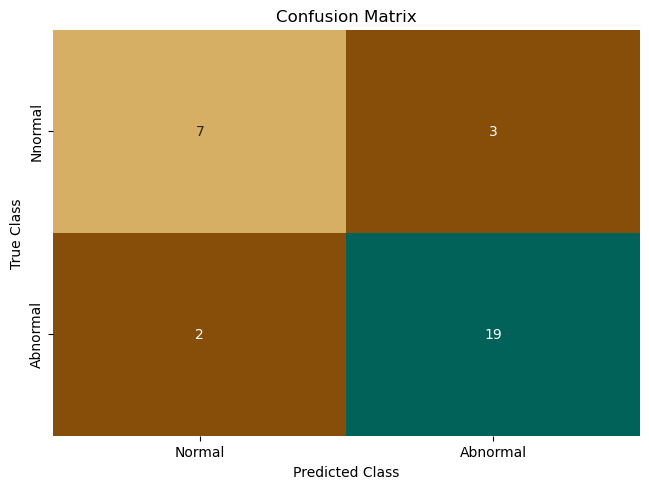

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

colormap = sns.color_palette("BrBG", 10)
sns.heatmap(df_confusion, annot=True, cbar=None, cmap=colormap)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.ylabel("True Class")
plt.xlabel("Predicted Class")
plt.show()

Step 3: Calculating performance statistics
If you want to compare this model to the next model that you create, you need some metrics that you can record. For a binary classification problem, the confusion matrix data can be used to calculate various metrics.

To start, extract the values from the confusion matrix cells into variables.

In [ ]:
bucket='ananyakeybucket'

In [ ]:
import warnings, requests, zipfile, io
warnings.simplefilter('ignore')
import pandas as pd
from scipy.io import arff

import os
import boto3
import sagemaker
from sagemaker.image_uris import retrieve
from sklearn.model_selection import train_test_split

In [ ]:
f_zip = 'https://ananyakeybucket.s3.amazonaws.com/vertebral_column_data.zip'
r = requests.get(f_zip, stream=True)
Vertebral_zip = zipfile.ZipFile(io.BytesIO(r.content))
Vertebral_zip.extractall()

data = arff.loadarff('column_2C_weka.arff')
df = pd.DataFrame(data[0])

class_mapper = {b'Abnormal':1,b'Normal':0}
df['class']=df['class'].replace(class_mapper)

cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]
df = df[cols]

train, test_and_validate = train_test_split(df, test_size=0.2, random_state=42, stratify=df['class'])
test, validate = train_test_split(test_and_validate, test_size=0.5, random_state=42, stratify=test_and_validate['class'])

prefix='lab3'

train_file='vertebral_train.csv'
test_file='vertebral_test.csv'
validate_file='vertebral_validate.csv'

s3_resource = boto3.Session().resource('s3')
def upload_s3_csv(filename, folder, dataframe):
    csv_buffer = io.StringIO()
    dataframe.to_csv(csv_buffer, header=False, index=False )
    s3_resource.Bucket(bucket).Object(os.path.join(prefix, folder, filename)).put(Body=csv_buffer.getvalue())

upload_s3_csv(train_file, 'train', train)
upload_s3_csv(test_file, 'test', test)
upload_s3_csv(validate_file, 'validate', validate)

container = retrieve('xgboost',boto3.Session().region_name,'1.0-1')

hyperparams={"num_round":"42",
             "eval_metric": "auc",
             "objective": "binary:logistic"}

s3_output_location="s3://{}/{}/output/".format(bucket,prefix)
xgb_model=sagemaker.estimator.Estimator(container,
                                       sagemaker.get_execution_role(),
                                       instance_count=1,
                                       instance_type='ml.m4.xlarge',
                                       output_path=s3_output_location,
                                        hyperparameters=hyperparams,
                                        sagemaker_session=sagemaker.Session())

train_channel = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/train/".format(bucket,prefix,train_file),
    content_type='text/csv')

validate_channel = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/validate/".format(bucket,prefix,validate_file),
    content_type='text/csv')

data_channels = {'train': train_channel, 'validation': validate_channel}

xgb_model.fit(inputs=data_channels, logs=False)

batch_X = test.iloc[:,1:];

batch_X_file='batch-in.csv'
upload_s3_csv(batch_X_file, 'batch-in', batch_X)

batch_output = "s3://{}/{}/batch-out/".format(bucket,prefix)
batch_input = "s3://{}/{}/batch-in/{}".format(bucket,prefix,batch_X_file)

xgb_transformer = xgb_model.transformer(instance_count=1,
                                       instance_type='ml.m4.xlarge',
                                       strategy='MultiRecord',
                                       assemble_with='Line',
                                       output_path=batch_output)

xgb_transformer.transform(data=batch_input,
                         data_type='S3Prefix',
                         content_type='text/csv',
                         split_type='Line')
xgb_transformer.wait()

s3 = boto3.client('s3')
obj = s3.get_object(Bucket=bucket, Key="{}/batch-out/{}".format(prefix,'batch-in.csv.out'))
target_predicted = pd.read_csv(io.BytesIO(obj['Body'].read()),names=['class'])

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
INFO:sagemaker.image_uris:Defaulting to only available Python version: py3
INFO:sagemaker.image_uris:Defaulting to only supported image scope: cpu.
INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2024-05-02-15-12-11-169



2024-05-02 15:12:16 Starting - Starting the training job..
2024-05-02 15:12:31 Starting - Preparing the instances for training.......
2024-05-02 15:13:10 Downloading - Downloading input data......
2024-05-02 15:13:45 Downloading - Downloading the training image........
2024-05-02 15:14:31 Training - Training image download completed. Training in progress....
2024-05-02 15:14:51 Uploading - Uploading generated training model..
2024-05-02 15:15:08 Completed - Training job completed

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2024-05-02-15-15-08-282


INFO:sagemaker:Creating transform job with name: sagemaker-xgboost-2024-05-02-15-15-08-937


.......................................
[2024-05-02:15:21:40:INFO] No GPUs detected (normal if no gpus installed)
[2024-05-02:15:21:40:INFO] No GPUs detected (normal if no gpus installed)
[2024-05-02:15:21:40:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;
  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }
  server {
    listen 8080 deferred;
    client_max_body_size 0;
    keepalive_timeout 3;
    location ~ ^/(ping|invocations|execution-parameters) {
      proxy_set_header X-Forwarded-For $proxy_add_x_forwarded_for;
      proxy_set_header Host $http_host;
      proxy_redirect off;
      proxy_read_timeout 60s;
      proxy_pass http://gunicorn;
    }
    location / {
      return 404 "{}";
    }
  }
}
[2024-05-02 15:21:40 +0000] [19] [INFO] Star

In [ ]:
def binary_convert(x):
    threshold = 0.3
    if x > threshold:
        return 1
    else:
        return 0

target_predicted_binary = target_predicted['class'].apply(binary_convert)

print(target_predicted_binary.head(5))
test.head(5)

0    1
1    1
2    1
3    1
4    1
Name: class, dtype: int64


,class,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis
136,1,88.024499,39.844669,81.774473,48.179830,116.601538,56.766083
230,0,65.611802,23.137919,62.582179,42.473883,124.128001,-4.083298
134,1,52.204693,17.212673,78.094969,34.992020,136.972517,54.939134
130,1,50.066786,9.120340,32.168463,40.946446,99.712453,26.766697
47,1,41.352504,16.577364,30.706191,24.775141,113.266675,-4.497958


In [ ]:
test_labels = test.iloc[:,0]
test_labels.head()

136    1
230    0
134    1
130    1
47     1
Name: class, dtype: int64

In [ ]:
from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(test_labels, target_predicted_binary)
df_confusion = pd.DataFrame(matrix, index=['Nnormal','Abnormal'],columns=['Normal','Abnormal'])

df_confusion

,Normal,Abnormal
Nnormal,7,3
Abnormal,2,19


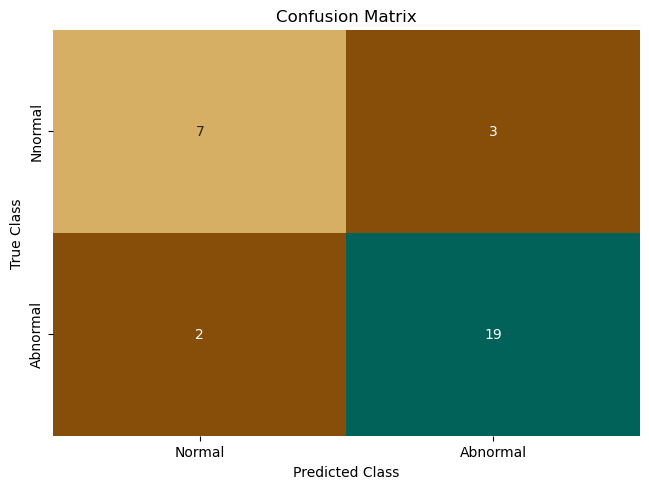

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

colormap = sns.color_palette("BrBG", 10)
sns.heatmap(df_confusion, annot=True, cbar=None, cmap=colormap)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.ylabel("True Class")
plt.xlabel("Predicted Class")
plt.show()

In [ ]:

from sklearn.metrics import roc_auc_score, roc_curve, auc

TN, FP, FN, TP = confusion_matrix(test_labels, target_predicted_binary).ravel()

print(f"True Negative (TN) : {TN}")
print(f"False Positive (FP): {FP}")
print(f"False Negative (FN): {FN}")
print(f"True Positive (TP) : {TP}")

True Negative (TN) : 7
False Positive (FP): 3
False Negative (FN): 2
True Positive (TP) : 19


In [ ]:
# Sensitivity, hit rate, recall, or true positive rate
Sensitivity  = float(TP)/(TP+FN)*100
print(f"Sensitivity or TPR: {Sensitivity}%")
print(f"There is a {Sensitivity}% chance of detecting patients with an abnormality have an abnormality")

Sensitivity or TPR: 90.47619047619048%
There is a 90.47619047619048% chance of detecting patients with an abnormality have an abnormality


In [ ]:
# Specificity or true negative rate
Specificity  = float(TN)/(TN+FP)*100
print(f"Specificity or TNR: {Specificity}%")
print(f"There is a {Specificity}% chance of detecting normal patients are normal.")


Specificity or TNR: 70.0%
There is a 70.0% chance of detecting normal patients are normal.


In [ ]:
# Precision or positive predictive value
Precision = float(TP)/(TP+FP)*100
print(f"Precision: {Precision}%")
print(f"You have an abnormality, and the probablity that is correct is {Precision}%")

Precision: 86.36363636363636%
You have an abnormality, and the probablity that is correct is 86.36363636363636%


In [ ]:
# Negative predictive value
NPV = float(TN)/(TN+FN)*100
print(f"Negative Predictive Value: {NPV}%")
print(f"You don't have an abnormality, but there is a {NPV}% chance that is incorrect" )

Negative Predictive Value: 77.77777777777779%
You don't have an abnormality, but there is a 77.77777777777779% chance that is incorrect


In [ ]:
# Fall out or false positive rate
FPR = float(FP)/(FP+TN)*100
print( f"False Positive Rate: {FPR}%")
print( f"There is a {FPR}% chance that this positive result is incorrect.")

False Positive Rate: 30.0%
There is a 30.0% chance that this positive result is incorrect.


In [ ]:
# False negative rate
FNR = float(FN)/(TP+FN)*100
print(f"False Negative Rate: {FNR}%")
print(f"There is a {FNR}% chance that this negative result is incorrect.")

False Negative Rate: 9.523809523809524%
There is a 9.523809523809524% chance that this negative result is incorrect.


In [ ]:
# False discovery rate
FDR = float(FP)/(TP+FP)*100
print(f"False Discovery Rate: {FDR}%" )
print(f"You have an abnormality, but there is a {FDR}% chance this is incorrect.")

False Discovery Rate: 13.636363636363635%
You have an abnormality, but there is a 13.636363636363635% chance this is incorrect.


In [ ]:
# Overall accuracy
ACC = float(TP+TN)/(TP+FP+FN+TN)*100
print(f"Accuracy: {ACC}%")

Accuracy: 83.87096774193549%


In [ ]:
print(f"Sensitivity or TPR: {Sensitivity}%")
print(f"Specificity or TNR: {Specificity}%")
print(f"Precision: {Precision}%")
print(f"Negative Predictive Value: {NPV}%")
print( f"False Positive Rate: {FPR}%")
print(f"False Negative Rate: {FNR}%")
print(f"False Discovery Rate: {FDR}%" )
print(f"Accuracy: {ACC}%")

Sensitivity or TPR: 90.47619047619048%
Specificity or TNR: 70.0%
Precision: 86.36363636363636%
Negative Predictive Value: 77.77777777777779%
False Positive Rate: 30.0%
False Negative Rate: 9.523809523809524%
False Discovery Rate: 13.636363636363635%
Accuracy: 83.87096774193549%


Step 4: Calculating the AUC-ROC Curve
The scikit-learn library has functions that can help you compute the area under the receiver operating characteristic curve (AUC-ROC).

The ROC is a probability curve.
The AUC tells you how well the model can distinguish between classes.
The AUC can be calculated. As you will see in the next lab, it can be used to measure the performance of the model.

In this example, the higher the AUC, the better the model is at distinguishing between abnormal and normal patients.

Depending on the value you set for the threshold, the AUC can change. You can plot the AUC by using the probability instead of your converted class.

In [ ]:
test_labels = test.iloc[:,0];
print("Validation AUC", roc_auc_score(test_labels, target_predicted) )

Validation AUC 0.8904761904761904


ValueError: Axis limits cannot be NaN or Inf

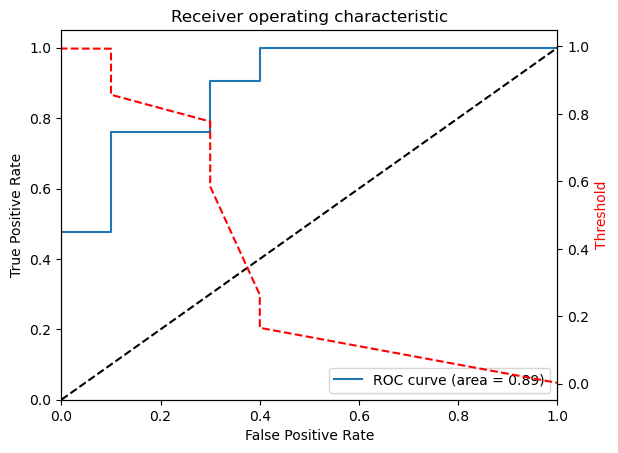

In [ ]:
fpr, tpr, thresholds = roc_curve(test_labels, target_predicted)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

# create the axis of thresholds (scores)
ax2 = plt.gca().twinx()
ax2.plot(fpr, thresholds, markeredgecolor='r',linestyle='dashed', color='r')
ax2.set_ylabel('Threshold',color='r')
ax2.set_ylim([thresholds[-1],thresholds[0]])
ax2.set_xlim([fpr[0],fpr[-1]])

print(plt.figure())